# ValueMonitor - Create your own topic model

This page is a visualisation of the ValueMonitor prototype. In case you would like to use the notebook, click on the icon ‘**Run in Google Colab**’ hereunder:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tristandewildt/ValueMonitor/blob/main/ValueMonitor_create_own_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tristandewildt/ValueMonitor/blob/main/ValueMonitor_create_own_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Table of content:
* [1. Import dataset and packages](#import_dataset_and_packages)
* [2. Creating the topic model](#creating_the_topic_model)
* [3. Verifying the topic model](#verifying_the_topic_model)
* [4. Gap assessment](#gap_assessment)
* [5. Impact assessment](#impact_assessment)
* [6. Values in different societal_groups](#values_in_different_societal_groups)

## 1. Import packages and dataset  <a name="import_dataset_and_packages"></a>

In this step, the relevant python packages are imported.

In [1]:
import sys, string, re
import pprint
import os
import pandas as pd
import dateutil.parser
import matplotlib.pyplot as plt
import spacy
from keybert import KeyBERT
from corextopic import vis_topic as vt
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.ticker import FormatStrFormatter
import pickle
import ipywidgets as widgets
from collections import Counter
from ipywidgets import interact, interact_manual
import nltk
from pprint import pprint
import seaborn as sns
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

sys.path.append('./code')

#from convert_to_df import *
from make_topic_model import *
from create_visualisation import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Trist\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Hereunder a dataset is imported from your computer.

In [7]:
''' Dataset '''

#df = pd.read_csv(r"C:\Users\tewdewildt\temp\combined.csv")
df = pd.read_csv(r"H:\SURFdrive\Postdoc\ET Lab\Research hydrogen\Data research hydrogen\data_wos\combined.csv")
df.info()

<ipython-input-7-1a9bbb4a891e>:4: DtypeWarning: Columns (2,3,4,6,7,10,11,14,15,16,17,18,19,25,26,27,30,32,38,39,40,41,47,49,51,52,55,58,59,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"H:\SURFdrive\Postdoc\ET Lab\Research hydrogen\Data research hydrogen\data_wos\combined.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253063 entries, 0 to 253062
Data columns (total 71 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PT      253063 non-null  object 
 1   AU      253011 non-null  object 
 2   BA      619 non-null     object 
 3   BE      20564 non-null   object 
 4   GP      6562 non-null    object 
 5   AF      253010 non-null  object 
 6   BF      633 non-null     object 
 7   CA      354 non-null     object 
 8   TI      253062 non-null  object 
 9   SO      253062 non-null  object 
 10  SE      20572 non-null   object 
 11  BS      13 non-null      object 
 12  LA      0 non-null       float64
 13  DT      252062 non-null  object 
 14  CT      34902 non-null   object 
 15  CY      34902 non-null   object 
 16  CL      34902 non-null   object 
 17  SP      11 non-null      object 
 18  HO      4895 non-null    object 
 19  DE      101400 non-null  object 
 20  ID      168797 non-null  object 
 21  AB      18

After the dataset is imported, one needs to indicate which colums the algorithm should consider as text (columns_to_select_as_text) and which as date (column_as_date). You can also indicate additional columns that you would like to keep for the rest of the analysis.

The option also exists to ask the algorithm to only use certain types of words to build the topic model (e.g. nouns or verbs). In some cases this increases the quality of the topics. The indication of the types of words to use is done through tagging. If you want to use tagging, set the wordtagging variable to True. The list of tages designating different types of words can be found here: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

In [8]:
df = df[df['PY'].notna()]
df['PY'] = df['PY'].astype('int')
df = df[df['NR'].notna()]
df['NR'] = df['NR'].astype('int')

In [9]:
''' Preparation of the dataset  '''

columns_to_select_as_text = ["TI", "DE", "AB"]
column_as_date = ["PY"]
other_columns_to_keep = ["AU", "AF", "SO", "CR", "WC", "SC", "NR"]

wordtagging = True # True, False
types_of_words_to_use = ['NN', 'NNP', 'NNS', #'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 
                         'JJ']

pd.options.mode.chained_assignment = None  # default='warn'

df = clean_df(df, columns_to_select_as_text, column_as_date, other_columns_to_keep, wordtagging, types_of_words_to_use)

## 2. Creating the topic model <a name="creating_the_topic_model"></a>

In this step, we create a topic model in which some of the topics refer to values. The creation of topics that reflect values is done by means of so-called 'anchor' words. These words guide the algorithm in the creation of topics that reflect values.

Anchor words are typically words that people use to refer to (the idea of) a value, such as synonyms. After adding some anchor words and running the model, the algorithm will automatically pick up other words that refer to the value. This is because the algorithm has observed that these words are often mentionned in the same documents as the anchor words.

Finding the right anchor words is typically an iterative process, by observing the new topic model created by the algorithm. Some anchor words need to be added to ensure that some aspect of the value are not left behind (to be placed in *dict_anchor_words* in the cell below). Other words need to be removed since they do not refer to the value (in *list_rejected_words* in the cell below).

We have prefilled an number of anchor words for each value.

In [2]:
dict_anchor_words = {

"Environmnental Sustainability" : ["sustainability", "sustainable", "renewable", "durable", "durability", 
                                  "sustainable development", "environmental", "climate change"],
"Safety" : ["safety", "accident", "accidents", "severe accident"],
"Economic viability" : ["economic viability", "economic", "economic potential", "costs", "cost effective"],
"Efficiency" : ["efficiency", "energy efficiency", "efficiency energy", "energy efficient", "efficient", 
                "efficiency improvement", "efficient energy", "efficient use"],
"Affordability": ["affordability", "affordable", "cheap", "expensive", "inexpensive"]}

list_rejected_words = [    "author exclusive", "exclusive licence", "licence springer", "licence",
    "academic publishers", "kluwer academic", "publishers", "kluwer", "academic", "chinese room", 
    "publishers artificial", "abstract available", "no abstract", "abstract", 
    "creative commons", "creative", "commons",
    "access article", "cc by", "by", "cc", "open access", "by nc", "article cc", "nd license", "nc nd", 
    "creativecommons", "creativecommons licenses", "licenses", "licenses nc", "nc",
    "american physical", "physical society", "chemical society", 
    "author exclusive", "exclusive", "license springer", "exclusive license", "author", "license", "exclusive licence", 
    "licence springer", "oxford", "oxford university", "gmbh germany",
    "iop", "iop publishing", "publishing ltd", "publishing", "licence iop",
    "mdpi basel", "basel switzerland", "mdpi", "basel", "licensee mdpi", "licensee", "authors licensee", 
    "publishing limited", "emerald", "emerald publishing",
    "nanyang", "nanyang technological", "technological university"
    "verlag", "springer verlag", "berlin", "berlin heidelberg", "heidelberg", 
    "verlag berlin", "springer", "verlag gmbh", "gmbh", "germany", 
    "elsevier ltd", "ltd", "elsevier", "ltd all", "copyright owner", "owner author", 
    "francis", "taylor francis", "francis group", "taylor", "group llc", 
    "ios press", "ios", "authors ios", "springer science", "business media", "science business", "media llc", "llc part", "llc",
    "ieee augmented", "copyright acm", "authors elsevier", "license creativecommons", "elsevier open",
    "tech publications", "publications switzerland",
    "publications lda", "scitepress science", "scitepress",
    "focus conference", "papers special",
    "nd", "authors elsevier",
    "proceedings papers", "proceedings", "papers", "topics", "papers topics", "conference", "workshop",
    "author reprints", "co uk", "journalspermissions", "permissions co", "reprints", "reprints permissions", "uk journalspermissions", "permissions",
    "springer nature", "part springer", "ltd part", "london ltd", "21st", "21st century",
    "sage", "sage publications", "publications all", "publications inc",
    "springer", "taylor", "francis", "taylor francis", "francis group", "springer nature", "llc", "group llc", 
    "elsevier", "author exclusive", "exclusive", "licence", "exclusive licence", "licence springer", "business media", 
    "springer science", "science business", "author", "abstract available", "media llc",
    "college all", "college", "minor", "blackwell", "blackwell publishing",
    "environmental kuznets", "kuznets", "kuznets curve", "ekc", "curve",
    "trading taylor", "limited trading", "informa uk", "uk limited", "trading", "uk",
    "publishers limited", "macmillan publishers", "macmillan",
    "horse", "white horse", "horse press", "white", "john wiley", "sons ltd", "john", "sons", "wiley sons", "wiley",
    "vch", "wiley vch", "vch verlag", "royal", "royal society", "society chemistry", "copyright asme", "asme",
    "paper", "alcohol"]

list_anchor_words_other_topics = [
    ["renewable energy", "peak", "storage", "power", "intermittent", "power generation", "electric power", "power system",
    "solar energy", "photovoltaic", "wind energy", "turbine"],
    ["vehicle", "vehicles", "hydrogen cars", "cars", "transport", "transportation", "mobility"],
    ["steel", "heating", "oil", "methanol", "refinery", "natural gas", "petrochemical", "chemical", "industry"], 
    ["nuclear", "nuclear power"],
    #["astronautics", "astronautics inc", "institute aeronautics", "aeronautics", "aeronautics astronautics", 
    #"astronomy", "astrophysics"],
    ["water splitting", "splitting"],
    #["system", "supply", "integrated", "energy systems", "energy supply", "system has"],
    ["transport", "vehicle", "bicarbonate", "biochemistry", "enzyme", "glucose", "mitochondrial", "protein", "metabolism", 
    "genes", "vacuoles", "nutrient", "microalgae"],
    ["law", "spectra", "spectrum", "stellar", "collimated", "pulsar", "polar", "coronal", "dwarf", "galaxies", "interstellar", 
     "clouds", "star", "law", "telescope", "supernova", "astronautics", "astronautics inc", "institute aeronautics", "aeronautics", "aeronautics astronautics", 
    "astronomy", "astrophysics"],
    ["seed", "oil", "fatty", "margarine", "soybean"], 
    ["noble", "noble metal", "noble metals", "medium", "copper", "secondary", "mode", "task"]
]



In [ ]:
number_of_topics_to_find = 400
number_of_documents_in_analysis = 1000

number_of_words_per_topic = 20

'''--------------------------------------------------------------------------''' 

model_and_vectorized_data = make_anchored_topic_model(df, number_of_topics_to_find, min(number_of_documents_in_analysis, len(df)), dict_anchor_words, list_anchor_words_other_topics, list_rejected_words)
topics = report_topics(model_and_vectorized_data[0], dict_anchor_words,number_of_words_per_topic)
df_with_topics = create_df_with_topics(df, model_and_vectorized_data[0], model_and_vectorized_data[1], number_of_topics_to_find)

In [10]:
number_of_words_per_topic = 10
for i, topic_ngrams in enumerate(model_and_vectorized_data[0].get_topics(n_words=number_of_words_per_topic)):
    topic_ngrams = [str(str(ngram[0]) + ", "+  str(round (ngram[1], 3))) for ngram in topic_ngrams if ngram[1] > 0]
    print(topic_ngrams)

['renewable, 1.118', 'sustainable, 0.74', 'sustainability, 0.148', 'climate change, 0.105', 'sustainable development, 0.05', 'sustainable energy, 0.044', 'global, 0.041', 'resources, 0.034', 'climate, 0.032', 'global warming, 0.024']
['safety, 1.742', 'accident, 0.225', 'accidents, 0.128', 'severe accident, 0.058', 'explosion, 0.034', 'risk, 0.029', 'vessel, 0.022', 'safety issues, 0.02', 'safe, 0.019', 'hydrogen safety, 0.018']
['economic, 0.972', 'costs, 0.699', 'techno economic, 0.037', 'techno, 0.036', 'economic viability, 0.029', 'investment, 0.025', 'economic environmental, 0.023', 'exergy, 0.022', 'feasibility, 0.02', 'economic feasibility, 0.02']
['efficient, 2.205', 'energy efficiency, 0.099', 'energy efficient, 0.052', 'efficiency energy, 0.025', 'efficiency, 0.025', 'efficient hydrogen, 0.023', 'efficient energy, 0.023', 'development efficient, 0.019', 'efficient use, 0.015', 'efficient catalysts, 0.014']
['inexpensive, 0.653', 'expensive, 0.535', 'cheap, 0.37', 'simple inex

In [3]:
with open('save/model_and_vectorized_data.pickle', "rb") as input_file:
    model_and_vectorized_data = cPickle.load(input_file)
with open('save/topics.pickle', "rb") as input_file:
    topics = cPickle.load(input_file)
#with open('save/df_with_topics.pickle', "rb") as input_file:
#    df_with_topics = cPickle.load(input_file)
with open('save/df_with_topics_WOS.pickle', "rb") as input_file:
    df_with_topics = cPickle.load(input_file)

In [4]:
dict_values = {"Environmnental Sustainability": 0,"Safety": 1,"Economic viability": 2,"Efficiency": 3,"Affordability": 4}
dict_domains = {"power generation": 5, "mobility": 6, "industry": 7}

In [5]:
dict_references = {'Authors': "AU", "References": "CR", "Research Areas": "WC", "Publication Name": "SO", 
                  "Document Title": "TI", "Author Keywords": "DE", "Abstract": "AB",
                  "Publication Year": "PY", "Authors": "AU", "Author Full Name": "AF",
                  "Citation counts": "NR"}



#{"AU": "Authors", "AF": "Author Full Name", "TI": "Document Title", 
#            "SO": "Publication Name", "DE": "Author Keywords", "AB": "Abstract",
#           "CR": "Cited References", "SO": "Publication Name", 
#            "NR": "Cited Reference Count", "PD": "Publication Date", 
#            "WC": "Web of Science Categories", "SC": "Research Areas", }
# https://images.webofknowledge.com/WOKRS535R83/help/WOS/hs_wos_fieldtags.html

#dict_name_domains = {"power_grid": "power generation", "mobility": "mobility", "industry": "industry"}


In [6]:
df_with_topics = df_with_topics[df_with_topics[dict_references["Document Title"]].str.contains("hydrogen", na=False) | df_with_topics[dict_references["Author Keywords"]].str.contains("hydrogen", na=False) | df_with_topics[dict_references["Abstract"]].str.contains("hydrogen", na=False) ]


In [11]:
#number_of_topics_to_find = 400
#number_of_documents_in_analysis = 4000

#number_of_words_per_topic = 20

#df_with_topics = create_df_with_topics(df, model_and_vectorized_data[0], model_and_vectorized_data[1], number_of_topics_to_find)

In [13]:
#with open('save/model_and_vectorized_data.pickle', 'wb') as handle:
#    pickle.dump(model_and_vectorized_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('save/topics.pickle', 'wb') as handle:
#    pickle.dump(topics, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('save/df_with_topics_WOS.pickle', 'wb') as handle:
#    pickle.dump(df_with_topics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
#import pickle5 as p

#with open('save/model_and_vectorized_data.pickle', "rb") as input_file:
#    model_and_vectorized_data = p.load(input_file)
#with open('save/topics.pickle', "rb") as input_file:
#    topics = p.load(input_file)
#with open('save/df_with_topics.pickle', "rb") as input_file:
#    df_with_topics = p.load(input_file)

C:\Users\tewdewildt\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
C:\Users\tewdewildt\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


## 3. Verifying the topic model   <a name="verifying_the_topic_model"></a>

To verify whether topics sufficiently refer to values, the code hereunder can be used to evaluate whether documents indeed address the value in question.

In [7]:
def plot_print_sample_articles_topic(selected_value, size_sample, window):
    show_extracts = True # True, False
    show_full_text  = False # True, False
    print_sample_articles_topic(df_with_topics, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)
widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], size_sample =(5,50, 5), window = (1,100, 1))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_print_sample_articles_topic(selected_value, size_sample, window)>

## 4. Description of datasets

In [89]:
resampling = "Y"
inv_dict_domains = {v: k for k, v in dict_domains.items()}

starttime = "1960"
endtime = "2023"

selected_dataset = df_with_topics.loc[(df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] <= dateutil.parser.parse(str(endtime)))]


df_frequencies = selected_dataset.set_index('date')
df_frequencies = df_frequencies.resample(resampling).sum()
df_frequencies = df_frequencies[list(dict_domains.values())]
df_frequencies = df_frequencies.rename(columns=inv_dict_domains)

df_frequencies.drop(df_frequencies.tail(1).index,inplace=True) # drop last n rows

n_colors = len(dict_domains)
colours = cm.Paired(np.linspace(0, 1, n_colors))

In [90]:
series_growth_of_science = [14.137, 14.716617, 15.3199983, 15.94811823, 16.60199107, 17.28267271, 17.99126229, 18.72890404, 19.49678911, 20.29615746, 21.12829992, 21.99456022, 22.89633718, 23.83508701, 24.81232558, 25.82963092, 26.88864579, 27.99108027, 29.13871456, 30.33340186, 31.57707133, 32.87173126, 34.21947224, 35.6224706, 37.0829919, 38.60339457, 40.18613374, 41.83376523, 43.5489496, 45.33445653, 47.19316925, 49.12808919, 51.14234085, 53.23917682, 55.42198307, 57.69428438, 60.05975004, 62.52219979, 65.08560998, 67.75411999, 70.53203891, 73.4238525, 76.43423046, 79.56803391, 82.8303233, 86.22636655, 89.76164758, 93.44187513, 97.27299201, 101.2611847, 105.4128933, 109.7348219, 114.2339496, 118.9175415, 123.7931607, 128.8686803, 134.1522962, 139.6525403]
df_frequencies['growth of science']= series_growth_of_science
colours = np.append(colours, [[0, 0, 0, 1]], axis = 0)

In [176]:
df_frequencies.sum()

power generation     14124.000000
mobility              2668.000000
industry             15016.000000
growth of science     3201.007183
dtype: float64

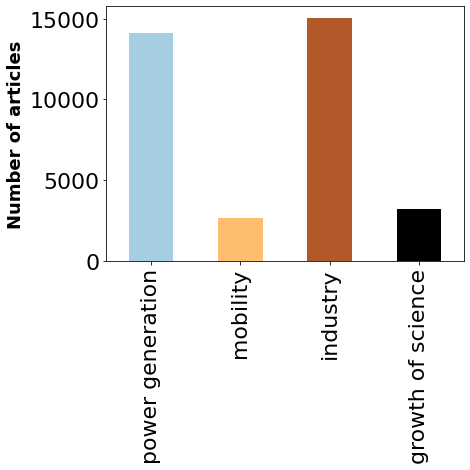

In [173]:
fig, ax1 = plt.subplots()
df_frequencies.sum().plot.bar(color=colours, figsize=(7,7))
ax1.set_ylabel('Number of articles', fontsize=18, fontweight="bold")
fig.tight_layout() 
#plt.figure(figsize=(14,14), dpi= 400)
#plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams.update({'font.size': 22})
plt.show()


In [174]:
colours

array([[0.65098039, 0.80784314, 0.89019608, 1.        ],
       [0.99215686, 0.74901961, 0.43529412, 1.        ],
       [0.69411765, 0.34901961, 0.15686275, 1.        ],
       [0.        , 0.        , 0.        , 1.        ]])

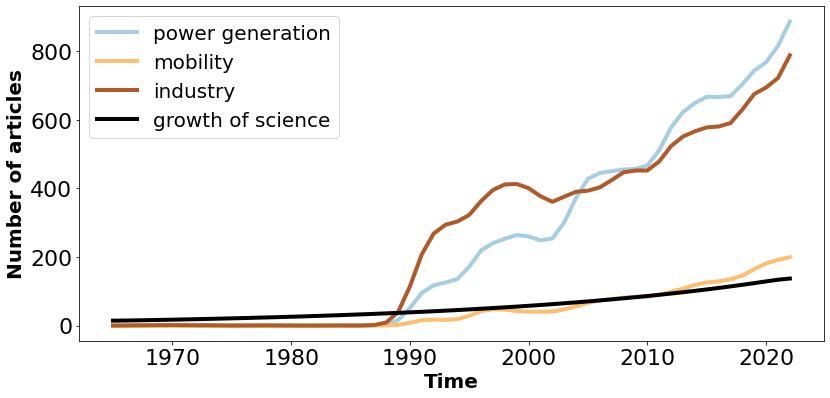

<Figure size 8000x5600 with 0 Axes>

In [175]:
smoothing = 0.3
fig, ax1 = plt.subplots()
x = pd.Series(df_frequencies.index.values)
x = x.dt.to_pydatetime().tolist()
    
x = [ z - relativedelta(years=1) for z in x]
sigma = (np.log(len(x)) - 1.25) * 1.2 * smoothing

counter = 0
for word in df_frequencies:
    ysmoothed = gaussian_filter1d(df_frequencies[word].tolist(), sigma=sigma)
    ax1.plot(x, ysmoothed, label=word, linewidth=4, color = colours[counter])
    counter = counter + 1
     
        
ax1.set_xlabel('Time', fontsize=20, fontweight="bold")
ax1.set_ylabel('Number of articles', fontsize=20, fontweight="bold")

ax1.legend(prop={'size': 20})
fig.tight_layout() 
plt.figure(figsize=(20,14), dpi= 400)
plt.rcParams["figure.figsize"] = [12,6]
plt.show()

## 5. Value Prioritization

The visualisation here can be used to evaluate the prioritization of values in the dataset.

In [7]:
def plot_vis_frequency_values(selected_domain):
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]
    create_vis_frequency_values(selected_dataset, dict_anchor_words)
widgets.interact(plot_vis_frequency_values, selected_domain=["power generation", "mobility", "industry"])

interactive(children=(Dropdown(description='selected_domain', options=('power generation', 'mobility', 'indust…

<function __main__.plot_vis_frequency_values(selected_domain)>

Text(0.5, 0, 'Number of articles')

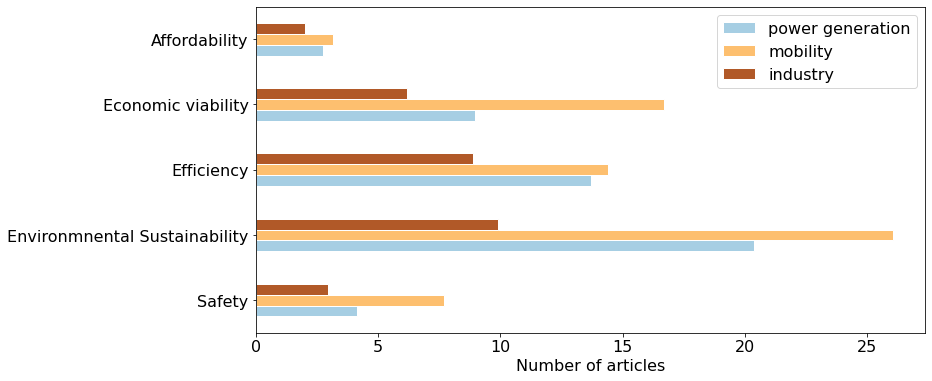

In [125]:

df_categories = pd.DataFrame()

for selected_domain in list(dict_domains.keys()):

    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]
    
    name_values = list(dict_anchor_words.keys())
    list_values_int = []
    for i in name_values:
        integ = topic_int_or_string(i, dict_anchor_words)
        list_values_int.append(integ)

   
    df_with_topics_sum_dataset_short = selected_dataset[[c for c in df_with_topics.columns if c in list_values_int]]
    df_with_topics_sum_dataset_short.columns = name_values
    df_sum_dataset_short = df_with_topics_sum_dataset_short.sum(numeric_only=True)
    series_perc_dataset_short = df_sum_dataset_short.apply(lambda x: x / len(df_with_topics_sum_dataset_short) * 100)
    series_perc_dataset_short = series_perc_dataset_short.sort_values(ascending=False)
    
    dict_dataset_short = series_perc_dataset_short.to_dict()
    #plt.figure(figsize=(10,len(list_values_int) / 2))
    #plt.barh(list(dict_dataset_short.keys()), list(dict_dataset_short.values()))
    #plt.gca().invert_yaxis()
    
    #plt.rcParams.update({'font.size': 16})
    #plt.title('Percentage of documents mentioning each value')
    #plt.xlabel('%')
    #plt.show()

    df_dataset_short = pd.DataFrame.from_dict(dict_dataset_short, orient='index')
    df_categories = pd.concat([df_categories, df_dataset_short], axis=1)

df_categories.columns = list(dict_domains.keys())
#list_top_categories = [*set(list_top_categories)]
#print(list_top_categories)
#df_categories = df_categories[df_categories.index.isin(list_top_categories)]
df_categories = df_categories.sort_index(ascending=False)
#print(df_categories)
#df_categories.columns = list_domains
#df_categories = df_categories.fillna(0)
ax = df_categories.plot(y=list(dict_domains.keys()), kind="barh", edgecolor='white', linewidth=1, color = colours)
ax.set_xlabel("Number of articles")
#ax.legend(bbox_to_anchor=(1, 0.275), prop={'size': 16})

In [122]:
df_categories

,power generation,mobility,industry
Environmnental Sustainability,20.351989,26.064227,9.890617
Efficiency,13.720521,14.413742,8.882446
Economic viability,8.954593,16.691561,6.174222
Safety,4.125308,7.692308,2.978387
Affordability,2.738472,3.174010,2.003163


In [ ]:
# comparison by dataset

In [13]:
def plot_print_sample_articles_topic(selected_value, selected_domain, window, size_sample):
    show_extracts = True # True, False
    show_full_text  = False # True, False
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]

    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], selected_domain=["power generation", "mobility", "industry"], window = (5,50, 5), size_sample =(5,50, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_print_sample_articles_topic(selected_value, selected_domain, window, size_sample)>

The code hereunder can be used to explore which topics are being discussed by documents addressing the selected value.

In [14]:
def plot_topics_in_dataset (selected_value, selected_domain, number_of_topics_to_find, number_of_documents_in_analysis, max_number_of_words_per_topic, top_topics_to_show):

    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]
    if selected_value != "No values":
         selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
    list_rejected_words2 = []
    return explore_topics_in_dataset(selected_dataset, number_of_topics_to_find, number_of_documents_in_analysis, max_number_of_words_per_topic, list_rejected_words2, top_topics_to_show)

my_interact_manual = interact_manual.options(manual_name="Find topics")
my_interact_manual(plot_topics_in_dataset, selected_value=[*dict_anchor_words, "No values"], selected_domain=["power generation", "mobility", "industry"],  number_of_topics_to_find = (5,100, 5), number_of_documents_in_analysis =(500,5000, 500), max_number_of_words_per_topic =(2,15, 2), top_topics_to_show=(5,20, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_topics_in_dataset(selected_value, selected_domain, number_of_topics_to_find, number_of_documents_in_analysis, max_number_of_words_per_topic, top_topics_to_show)>

The code hereunder can be used to explore which articles address the selected value.

In [160]:
def plot_print_sample_articles_topic(selected_value, selected_domain, window, size_sample):
    show_extracts = True # True, False
    show_full_text  = False # True, False
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], selected_domain=["power generation", "mobility", "industry"],  window = (5,50, 5), size_sample =(5,50, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_print_sample_articles_topic(selected_value, selected_domain, window, size_sample)>

## 6. Values over time

The code hereunder can be used to study how the frequency of values has changed over time

interactive(children=(Dropdown(description='selected_domain', options=('power generation', 'mobility', 'indust…

<function __main__.plot_create_vis_values_over_time(selected_domain, resampling, starttime, endtime, smoothing, max_value_y)>

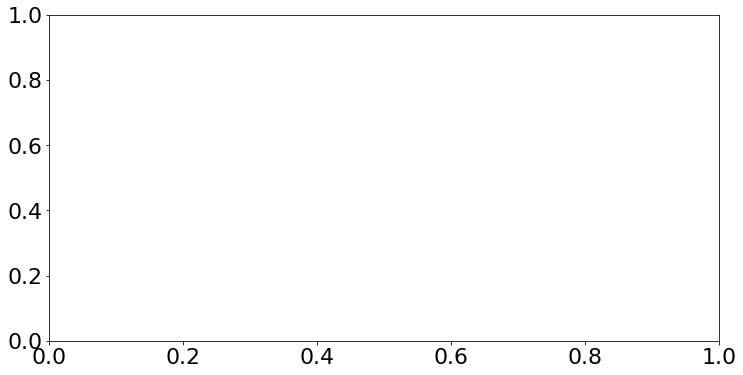

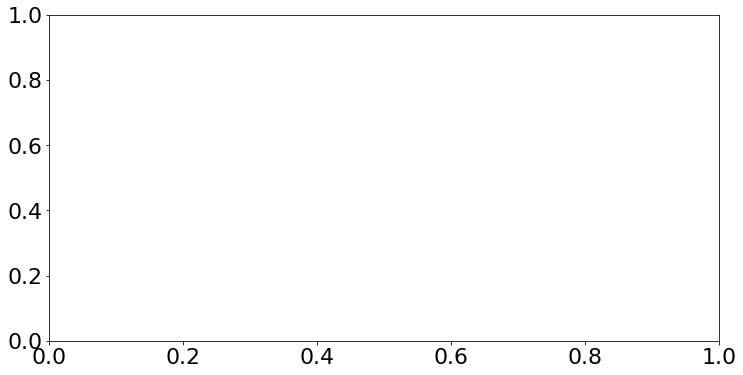

In [18]:
def plot_create_vis_values_over_time (selected_domain, resampling, starttime, endtime, smoothing, max_value_y):
    values_to_include_in_visualisation = []
    #values_to_include_in_visualisation = ['Efficiency', 'Sustainability']

    resampling_dict = {"Year": "Y", "Month": "M", "Day": "D"}
    resampling = resampling_dict[resampling]
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]
    selected_dataset = selected_dataset.loc[(selected_dataset['date'] >= dateutil.parser.parse(str(starttime))) & (selected_dataset['date'] <= dateutil.parser.parse(str(endtime)))]
    create_vis_values_over_time(selected_dataset, dict_anchor_words, resampling, values_to_include_in_visualisation, smoothing, max_value_y)  
    
widgets.interact(plot_create_vis_values_over_time, selected_domain=["power generation", "mobility", "industry"], smoothing = (0.25,3, 0.25), max_value_y = (5,100, 5), resampling = ["Year", "Month", "Day"], starttime =(1960,2022, 2), endtime =(1960,2022, 2))

In [8]:
topics_to_remove = [131, 79, 387, 165, 113, 310, 185, 309, 189, 76, 14, 37]
df_with_topics_reduced = df_with_topics.drop(topics_to_remove, axis=1)

In [9]:
starttime = 1960
endtime = 1970

selected_dataset = df_with_topics.loc[(df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] <= dateutil.parser.parse(str(endtime)))]

list_int_topics = [*range(400)]
df_with_topics_reduced_int = selected_dataset[list_int_topics]
df_with_topics_reduced_int = df_with_topics_reduced_int.drop(topics_to_remove, axis=1)
series_with_topics_reduced_int_sum = df_with_topics_reduced_int.sum()
df_with_topics_reduced_int_sum = pd.DataFrame(series_with_topics_reduced_int_sum)
df_with_topics_reduced_int_sum.rename({0: 'count'}, axis=1, inplace=True)
list_indexes = list(df_with_topics_reduced_int_sum.index)
list_indexes_names = []
for i in list_indexes:
    list_indexes_names.append("Topic "+str(i)+": "+str(topics[i]))
df_with_topics_reduced_int_sum['topics']=list_indexes_names
df_with_topics_reduced_int_sum.set_index('topics')
df_with_topics_reduced_int_sum.sort_values(by='count', ascending=False).head(20)


,count,topics
11,46.0,"Topic 11: ['spectra', 'spectrum', 'spectroscop..."
377,41.0,"Topic 377: ['bond', 'bonds', 'hydrogen bond', ..."
367,31.0,"Topic 367: ['atom', 'atoms', 'active site', 's..."
361,26.0,"Topic 361: ['length', 'laser', 'excitation', '..."
394,25.0,"Topic 394: ['reaction', 'evolution reaction', ..."
384,17.0,"Topic 384: ['rates', 'ratios', 'latter', 'init..."
280,16.0,"Topic 280: ['theory', 'calculations', 'dft', '..."
269,16.0,"Topic 269: ['corrosion', 'tests', 'decay', 'sm..."
65,16.0,"Topic 65: ['method', 'method hydrogen', 'new m..."
63,14.0,"Topic 63: ['complex', 'earlier', 'improved', '..."


interactive(children=(Dropdown(description='selected_domain', options=('power generation', 'mobility', 'indust…

<function __main__.plot_create_vis_values_over_time(selected_domain, resampling, starttime, endtime, smoothing, max_value_y)>

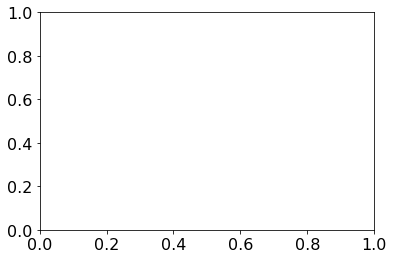

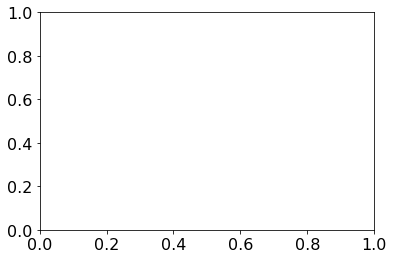

In [10]:
def plot_create_vis_values_over_time (selected_domain, resampling, starttime, endtime, smoothing, max_value_y):
    values_to_include_in_visualisation = []
    #values_to_include_in_visualisation = ['Efficiency', 'Sustainability']

    resampling_dict = {"Year": "Y", "Month": "M", "Day": "D"}
    resampling = resampling_dict[resampling]
    selected_dataset = df_with_topics_reduced.loc[(df_with_topics_reduced[dict_domains[selected_domain]] == 1)]
    selected_dataset = selected_dataset.loc[(selected_dataset['date'] >= dateutil.parser.parse(str(starttime))) & (selected_dataset['date'] <= dateutil.parser.parse(str(endtime)))]
    create_vis_values_over_time(selected_dataset, dict_anchor_words, resampling, values_to_include_in_visualisation, smoothing, max_value_y)  
    
widgets.interact(plot_create_vis_values_over_time, selected_domain=["power generation", "mobility", "industry"], smoothing = (0.25,3, 0.25), max_value_y = (5,100, 5), resampling = ["Year", "Month", "Day"], starttime =(1960,2022, 2), endtime =(1960,2022, 2))

In [11]:
list_int_topics
list_selected_topics = [x for x in list_int_topics if x not in topics_to_remove]
dict_topics = {}
for i in list_selected_topics:
    dict_topics[i]=', '.join(topics[i][:5])

Topic 5: power, storage, renewable energy, power generation, photovoltaic
Topic 210: high, high efficiency, high hydrogen, high quality, process high
Topic 265: cell, fuel cell, cells, fuel cells, electrolysis
Topic 262: fuel, hydrogen fuel, fossil fuel, fuel production, fuel energy
Topic 152: gas, hydrogen gas, gases, gas hydrogen, power gas
Topic 52: temperature, high temperature, room temperature, low temperature, room
Topic 255: production, hydrogen production, production hydrogen, energy production, production water
Topic 336: such, such hydrogen, techniques such, such high, methods such
Topic 0: renewable, sustainable, sustainability, climate change, sustainable development
Topic 123: energy, energy conversion, conversion, clean, clean energy


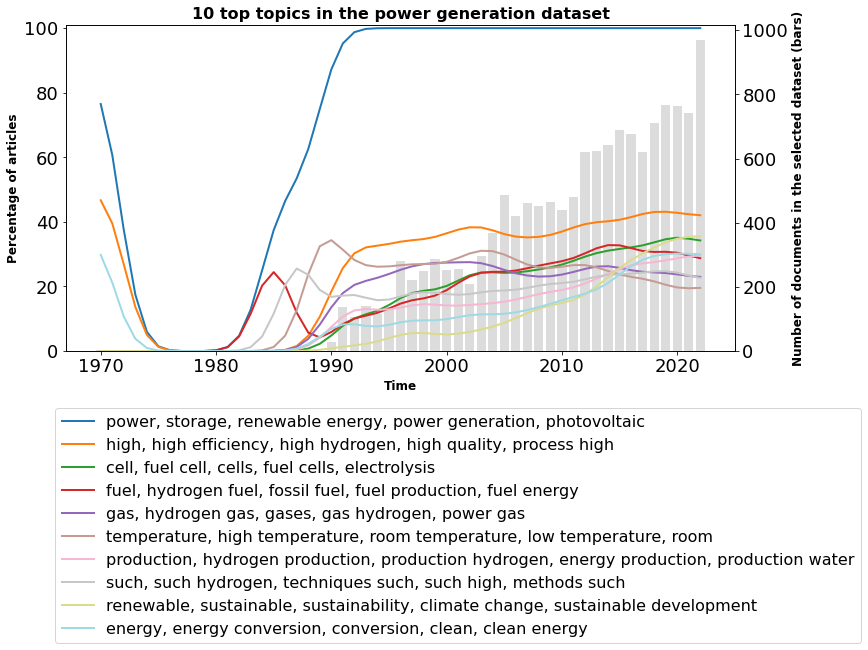

In [75]:
# vis most frequent topics
top_topics_to_show = 10

readjust_colors = 11
max_value_y = 101
starttime = "1960"
endtime = "2022"
smoothing = .5
resampling = "Y"
selected_domain = "power generation" #"power generation", "mobility", "industry"

#df_with_topics_reduced_int = selected_dataset[[*range(400)]]

df_to_evaluate = df_with_topics
df_to_evaluate = df_to_evaluate.loc[(df_to_evaluate[dict_domains[selected_domain]] == 1) & (df_to_evaluate['date'] >= dateutil.parser.parse(str(starttime))) & (df_to_evaluate['date'] <= dateutil.parser.parse(str(endtime)))]
df_to_evaluate = df_to_evaluate.set_index('date')  
        
df_with_topics_freq = df_to_evaluate.resample(resampling).size().reset_index(name="count")
df_with_topics_freq = df_with_topics_freq.set_index('date')
      
df_to_evaluate = df_to_evaluate.fillna("")

df_to_evaluate = df_to_evaluate[list(dict_topics.keys())]
#print(df_to_evaluate)
#df_to_evaluate = df_to_evaluate.drop(columns=topics_to_remove)

df_to_evaluate = df_to_evaluate.resample(resampling).sum()
count_df_to_evaluate = df_to_evaluate.sum().sort_values(ascending = False)
initial_number_topics = len(count_df_to_evaluate)
count_df_to_evaluate = count_df_to_evaluate[:top_topics_to_show]



percentage_df_to_evaluate = count_df_to_evaluate.divide(count_df_to_evaluate.sum(), fill_value=0)
percentage_df_to_evaluate = percentage_df_to_evaluate * 100
list_topics_above_threshold = list(count_df_to_evaluate.index.values)

#print topics
for topic in list_topics_above_threshold:
    print("Topic "+str(list(dict_topics.keys()).index(topic))+": "+str(dict_topics[topic]))


df_to_evaluate = df_to_evaluate[list_topics_above_threshold]
    
df_to_evaluate = df_to_evaluate.div(df_with_topics_freq["count"], axis=0)
df_to_evaluate = df_to_evaluate.fillna(0)
    
     
x = pd.Series(df_to_evaluate.index.values)
x = x.dt.to_pydatetime().tolist()
    
x = [ z - relativedelta(years=1) for z in x]
      
df_to_evaluate = df_to_evaluate * 100

    
sigma = (np.log(len(x)) - 1.25) * 1.2 * smoothing
        
colours = cm.tab20(np.linspace(0, 1, math.ceil(len(list_topics_above_threshold))))
colours_long = []
for i in range(readjust_colors):
    for y in colours:
        colours_long.append(y)


        
dict_colors = {}
counter = 0
for word in list_topics_above_threshold:
    dict_colors[word] = colours_long[counter]
    counter = counter + 1

counter = 0
fig, ax1 = plt.subplots()
for word in df_to_evaluate:
    ysmoothed = gaussian_filter1d(df_to_evaluate[word].tolist(), sigma=sigma)
    ax1.plot(x, ysmoothed, label=dict_topics[word], linewidth=2, color = dict_colors[word])
    counter = counter + 1
        
ax1.set_xlabel('Time', fontsize=12, fontweight="bold")
ax1.set_ylabel('Percentage of articles', fontsize=12, fontweight="bold")
ax1.legend(prop={'size': 10})
    
timestamp_0 = x[0]
timestamp_1 = x[1]
    

#width = (time.mktime(timestamp_1.timetuple()) - time.mktime(timestamp_0.timetuple())) / 86400 *.8
width = (timestamp_1 - timestamp_0).total_seconds() / 86400 * 0.8
    
df_to_evaluate["count"]=df_with_topics_freq["count"]
    
ax2 = ax1.twinx()
ax2.bar(x, df_to_evaluate["count"].tolist(), width=width, color='gainsboro')
ax2.set_ylabel('Number of documents in the selected dataset (bars)', fontsize=12, fontweight="bold")
    
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

        
ax1.set_ylim([0,max_value_y])
ax1.legend(bbox_to_anchor=(1.2, -0.15), prop={'size': 16})
    
plt.rcParams["figure.figsize"] = [12,6]
plt.title(str(top_topics_to_show)+" top topics in the "+str(selected_domain)+" dataset", fontsize=16, fontweight="bold")
plt.show()

14192
9151


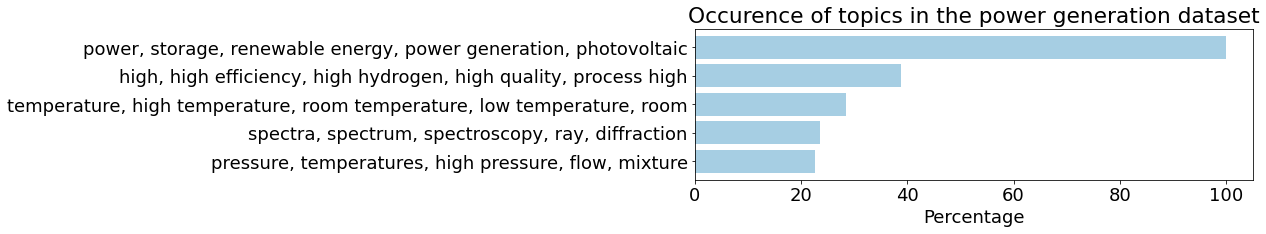

In [108]:
top_topics_to_show = 5
starttime = "1960"
endtime = "2023"
selected_domain = "power generation" #"power generation", "mobility", "industry"

df_to_evaluate = df_with_topics
df_to_evaluate = df_to_evaluate.loc[(df_to_evaluate[dict_domains[selected_domain]] == 1) & (df_to_evaluate['date'] >= dateutil.parser.parse(str(starttime))) & (df_to_evaluate['date'] <= dateutil.parser.parse(str(endtime)))]

print(len(df_to_evaluate))
for i in range(5):
    df_to_evaluate = df_to_evaluate.loc[(df_to_evaluate[i] == 0)]
print(len(df_to_evaluate))
df_to_evaluate = df_to_evaluate[list(dict_topics.keys())]

df_with_topics_sum_dataset_short = df_to_evaluate
df_sum_dataset_short = df_with_topics_sum_dataset_short.sum(numeric_only=True)
series_perc_dataset_short = df_sum_dataset_short.apply(lambda x: x / len(df_with_topics_sum_dataset_short) * 100)
series_perc_dataset_short = series_perc_dataset_short.sort_values(ascending=False)
series_perc_dataset_short = series_perc_dataset_short [:top_topics_to_show]
    
dict_dataset_short = series_perc_dataset_short.to_dict()

dict_dataset_short = {key: dict_dataset_short[key] for key in dict_dataset_short if key not in topics_to_remove}

dict_dataset_short = dict((dict_topics[key], value) for (key, value) in dict_dataset_short.items())
dict_dataset_short



plt.figure(figsize=(10,len(dict_dataset_short) / 1.8))
plt.barh(list(dict_dataset_short.keys()), list(dict_dataset_short.values()), color = colours[dict_domains[selected_domain] - 5])
plt.gca().invert_yaxis()
    
plt.rcParams.update({'font.size': 18})
plt.title('Occurence of topics in the '+str(selected_domain)+' dataset')
plt.xlabel('Percentage')
plt.show()

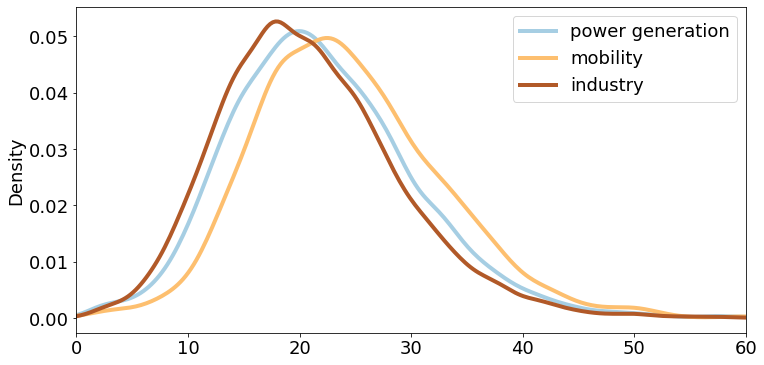

In [94]:
top_topics_to_show = 5
starttime = "1960"
endtime = "2022"
#selected_domain = "industry" #"power generation", "mobility", "industry"

df_distribution_number_topics = pd.DataFrame({})
for selected_domain in list(dict_domains.keys()):
    

    df_to_evaluate = df_with_topics
    df_to_evaluate = df_to_evaluate.loc[(df_to_evaluate[dict_domains[selected_domain]] == 1) & (df_to_evaluate['date'] >= dateutil.parser.parse(str(starttime))) & (df_to_evaluate['date'] <= dateutil.parser.parse(str(endtime)))]
    df_to_evaluate = df_to_evaluate[list(dict_topics.keys())]

    series_to_evaluate = df_to_evaluate.sum(axis = 1)
    series_to_evaluate = series_to_evaluate.rename(selected_domain)
    new_df = pd.DataFrame({selected_domain: series_to_evaluate})
    df_distribution_number_topics = pd.concat([df_distribution_number_topics, new_df])

#sns.distplot(df_distribution_number_topics, hist=False, kde_kws={'clip': (0.0, 50.0)})
    
    
ax = df_distribution_number_topics.plot.kde(linewidth=4, color = colours)

plt.xlim(0, 60)
plt.legend()
plt.show()

What are other topics that are being discussed (besides values)?

In [15]:
def vis_most_important_topics(selected_domain, x_most_frequent_topics_to_select, starttime, endtime):

    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] <= dateutil.parser.parse(str(endtime)))]
    topics_int = [x for x in list(topics.keys()) if not isinstance(x, str)]
    selected_dataset_freq = selected_dataset[topics_int]
    selected_dataset_count = selected_dataset_freq.sum(axis = 0)
    selected_dataset_count = selected_dataset_count.sort_values(ascending=False)
    selected_dataset_count = selected_dataset_count[:x_most_frequent_topics_to_select]
    list_selected_dataset_count = selected_dataset_count.index.tolist()
    list_topics = []
    for i in list_selected_dataset_count:
        list_topics.append(topics[i][0:5])
    new_selected_dataset = pd.DataFrame(selected_dataset_count)  
    new_selected_dataset['topics']=list_topics
    new_selected_dataset = new_selected_dataset.set_index('topics')


    plt.rcParams.update({'font.size': 12})
    ax = new_selected_dataset.plot(kind='barh', figsize=(18,6))
    ax.set_xlabel("counts")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    print("Length of dataset: "+str(len(selected_dataset)))
    plt.title(str(x_most_frequent_topics_to_select)+" most frequent topics in the selected dataset", fontdict={'fontsize': 16})

widgets.interact(vis_most_important_topics, selected_domain=["power generation", "mobility", "industry"], x_most_frequent_topics_to_select = (3,20, 1), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Dropdown(description='selected_domain', options=('power generation', 'mobility', 'indust…

<function __main__.vis_most_important_topics(selected_domain, x_most_frequent_topics_to_select, starttime, endtime)>

The code hereunder can be used to explore which topics are being discussed by documents addressing the selected value in the selected timeframe.

In [16]:
def plot_topics_in_dataset (selected_value, selected_domain, starttime, endtime, number_of_topics_to_find, number_of_documents_in_analysis, number_of_words_per_topic, top_topics_to_show):

    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] <= dateutil.parser.parse(str(endtime)))]
    if selected_value != "No values":
         selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]

    list_rejected_words2 = []
    return explore_topics_in_dataset(selected_dataset, number_of_topics_to_find, number_of_documents_in_analysis, number_of_words_per_topic, list_rejected_words2, top_topics_to_show)

my_interact_manual = interact_manual.options(manual_name="Find topics")
my_interact_manual(plot_topics_in_dataset, selected_value=[*dict_anchor_words, "No values"], selected_domain=["power generation", "mobility", "industry"],  number_of_topics_to_find = (5,50, 5), number_of_documents_in_analysis =(500,5000, 500), number_of_words_per_topic =(5,30, 5), starttime =(1960,2023, 5), endtime =(1960,2025, 5), top_topics_to_show =(5,20, 2))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_topics_in_dataset(selected_value, selected_domain, starttime, endtime, number_of_topics_to_find, number_of_documents_in_analysis, number_of_words_per_topic, top_topics_to_show)>

The code hereunder can be used to explore which articles address the selected value in the selected timeframe.

In [90]:
def plot_print_sample_articles_topic(selected_value, selected_domain, starttime, endtime, window, size_sample, ):
    show_extracts = True # True, False
    show_full_text  = False # True, False
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] <= dateutil.parser.parse(str(endtime)))]
    selected_dataset = selected_dataset.loc[(selected_dataset['date'] >= dateutil.parser.parse(str(T0))) & (selected_dataset['date'] <= dateutil.parser.parse(str(T1)))]
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], selected_domain=["power generation", "mobility", "industry"],  window = (5,50, 5), size_sample =(5,50, 5), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_print_sample_articles_topic(selected_value, selected_domain, starttime, endtime, window, size_sample)>

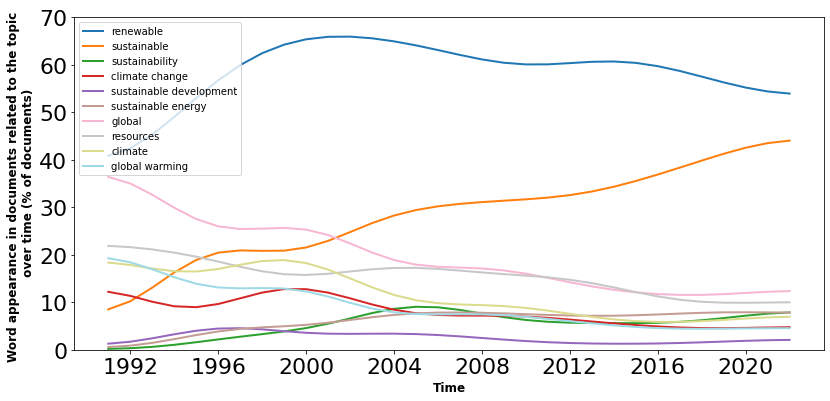

<Figure size 8000x5600 with 0 Axes>

In [194]:
topic_to_evaluate = 0
top_words = 10
#list_words = ['renewable', 'sustainable', 'sustainability', 'energy sources', 'sustainable development', 'sources', 'climate', 'resources', 'renewable hydrogen', 'sustainable energy', 'climate change', 'hydrogen renewable', 'renewable sources', 'durability', 'renewable resources', 'production renewable', 'alternative', 'option', 'sustainable hydrogen', 'energy resources']
#list_words = ['alternative', 'option']
list_words = topics[topic_to_evaluate][:top_words]
resampling = 'Y'
smoothing = 1
max_value_y = 70
starttime = "1985"
endtime = "2022"

df_to_evaluate = df_with_topics
df_to_evaluate = df_to_evaluate.loc[(df_to_evaluate['date'] >= dateutil.parser.parse(str(starttime))) & (df_to_evaluate['date'] <= dateutil.parser.parse(str(endtime)))]


inspect_words_over_time(df_to_evaluate, topic_to_evaluate, list_words, resampling, smoothing, max_value_y)

## 7. Export to VOS Viewer

In [ ]:
dict_anchor_words = {

"Environmnental Sustainability" : ["sustainability", "sustainable", "renewable", "durable", "durability", 
                                  "sustainable development", "environmental"],
"Safety" : ["safety", "accident", "accidents", "severe accident"],
"Economic viability" : ["economic viability", "economic", "economic potential", "costs", "cost effective"],
"Efficiency" : ["efficiency", "energy efficiency", "efficiency energy", "energy efficient", "efficient", 
                "efficiency improvement", "efficient energy", "efficient use"],
"Affordability": ["affordability", "affordable", "cheap", "expensive"]
    

}

In [23]:
dict_domains = {"power generation": 5, "mobility": 6, "industry": 7}
dict_values = {"Environmnental Sustainability": 0,"Safety": 1,"Economic viability": 2,"Efficiency": 3,"Affordability": 4}

In [24]:
def save_dataset_incremental(selected_value, selected_domain, starttime, endtime):
    while starttime < endtime:
        selected_dataset = df_with_topics.loc[(df_with_topics[dict_values[selected_value]] == 1) & (df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(starttime + 5)))]

        name = "df_with_topics_"+str(selected_domain)+"_"+str(selected_value)+"_"+str(starttime)+"_"+str(starttime + 5)+""
        selected_dataset.to_csv("H:\SURFdrive\Postdoc\ET Lab\Research hydrogen\Data research hydrogen\Data_citation_networks/"+str(name)+".csv", index=False)
        starttime = starttime + 5
my_interact_manual = interact_manual.options(manual_name="Save datasets")
my_interact_manual(save_dataset_incremental, selected_value=[*dict_anchor_words], selected_domain = list(dict_domains.keys()), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.save_dataset_incremental(selected_value, selected_domain, starttime, endtime)>

In [29]:
def save_dataset_start_to_end(selected_value, selected_domain, starttime, endtime):
    increment = starttime + 5
    while increment <= endtime:
        selected_dataset = df_with_topics.loc[(df_with_topics[dict_values[selected_value]] == 1) & (df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(increment)))]
    
        name = "df_with_topics_"+str(selected_domain)+"_"+str(selected_value)+"_"+str(starttime)+"_"+str(increment)+""
        selected_dataset.to_csv("H:\SURFdrive\Postdoc\ET Lab\Research hydrogen\Data research hydrogen\Data_citation_networks/"+str(name)+".csv", index=False)
        increment = increment + 5
my_interact_manual = interact_manual.options(manual_name="Save datasets")
my_interact_manual(save_dataset_start_to_end, selected_value=[*dict_anchor_words], selected_domain = list(dict_domains.keys()), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.save_dataset_start_to_end(selected_value, selected_domain, starttime, endtime)>

## 8. Extract specific articles in citation network

In [91]:
def plot_print_sample_articles_topic(selected_value, selected_domain, starttime, endtime, window, size_sample):

    show_extracts = True # True, False
    show_full_text  = False # True, False
    dict_domains = {"power generation": 5, "mobility": 6, "industry": 7}
    if selected_value == "No value":
        selected_value = dict_domains[selected_domain]
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

#widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], selected_dataset = list_datasets,  window = (5,50, 5), size_sample =(5,50, 5))
widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"],  window = (5,100, 5), size_sample =(5,50, 5), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_print_sample_articles_topic(selected_value, selected_domain, starttime, endtime, window, size_sample)>

Find article written by the author

In [89]:
def plot_print_sample_articles_topic(selected_author, selected_value, selected_domain, starttime, endtime, window, size_sample):

    show_extracts = False # True, False
    show_full_text  = True # True, False
    if selected_value == "No value":
        selected_value = dict_domains[selected_domain]
    else:
        selected_value = dict_values[selected_value]
    selected_dataset = df_with_topics.loc[(df_with_topics[selected_value] == 1) & (df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]
    selected_dataset = selected_dataset[selected_dataset[dict_references['Authors']].str.contains(selected_author, na=False)]
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)
widgets.interact(plot_print_sample_articles_topic, selected_author = widgets.Text(), selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"],  window = (5,100, 5), size_sample =(5,50, 5), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Text(value='', description='selected_author'), Dropdown(description='selected_value', op…

<function __main__.plot_print_sample_articles_topic(selected_author, selected_value, selected_domain, starttime, endtime, window, size_sample)>

Find article citing the author

In [44]:
def plot_print_sample_articles_topic(selected_author, selected_value, selected_domain, starttime, endtime, window, size_sample):

    show_extracts = True # True, False
    show_full_text  = False # True, False
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]
    if selected_value != "No value":
        selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
    selected_dataset = selected_dataset[selected_dataset[dict_references["References"]].str.contains(selected_author, na=False)]
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)
widgets.interact(plot_print_sample_articles_topic, selected_author = widgets.Text(), selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"],  window = (5,100, 5), size_sample =(5,50, 5), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Text(value='', description='selected_author'), Dropdown(description='selected_value', op…

<function __main__.plot_print_sample_articles_topic(selected_author, selected_value, selected_domain, starttime, endtime, window, size_sample)>

## 9. Explore scientific fields over time

In [28]:
list_string = df_with_topics[dict_references["Research Areas"]].str.cat(sep=';')
list_split = list_string.split(';') 
list_split_all=[x.strip(' ') for x in list_split]
count = Counter(list_split_all) 
list_of_categories=list(count.keys())
list_of_categories.sort()
len(list_of_categories)

231

In [11]:
starttime = 1990
endtime = starttime + 1
selected_domain = "mobility"

selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]
print(len(selected_dataset))

10


In [75]:
def plot_explore_disciplines_over_time (selected_domain, selected_value, resampling, threshold_percentage_categories, smoothing, max_value_y, readjust_colors):
    resampling_dict = {"Year": "Y", "Month": "M", "Day": "D"}
    resampling = resampling_dict[resampling]
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]
 
    if selected_value != "No value":
        selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
    explore_disciplines_over_time(selected_dataset, dict_references["Research Areas"], threshold_percentage_categories, resampling, smoothing, max_value_y, list_of_categories, readjust_colors)

my_interact_manual = interact_manual.options(manual_name="Plot results")
my_interact_manual(plot_explore_disciplines_over_time, selected_domain = ["power generation", "mobility", "industry"], selected_value=[*dict_anchor_words, "No value"], smoothing = (0.25,3, 0.25), max_value_y = (5,100, 5), resampling = ["Year", "Month", "Day"], threshold_percentage_categories = (0, 20, 0.1), readjust_colors = (1,20, 1))

interactive(children=(Dropdown(description='selected_domain', options=('power generation', 'mobility', 'indust…

<function __main__.plot_explore_disciplines_over_time(selected_domain, selected_value, resampling, threshold_percentage_categories, smoothing, max_value_y, readjust_colors)>

['Electrochemistry', 'Engineering, Electrical & Electronic', 'Engineering, Chemical', 'Energy & Fuels', 'Chemistry, Multidisciplinary', 'Chemistry, Physical', 'Materials Science, Multidisciplinary']
                                         0     0     0
Materials Science, Multidisciplinary  3857   406  3300
Engineering, Electrical & Electronic  1760   479   604
Engineering, Chemical                 1935   408  3419
Energy & Fuels                        5633  1314  4598
Electrochemistry                      2340   474  1463
Chemistry, Physical                   4477   653  4052
Chemistry, Multidisciplinary          2035   212  2053


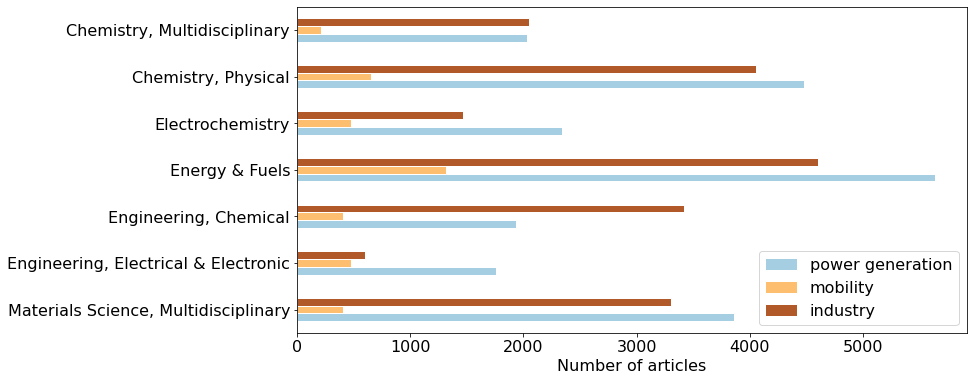

In [96]:
top_categories = 5

list_domains = ["power generation", "mobility", "industry"]
dict_of_dict_domains = {}
df_categories = pd.DataFrame()
list_top_categories = []




for domain in list_domains:
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[domain]] == 1)]
    selected_dataset = selected_dataset.fillna("")
    df_category = pd.DataFrame() 
    for word in list_of_categories:
        new_df = pd.DataFrame()
        new_df[word] = selected_dataset[dict_references["Research Areas"]].str.contains(pat = word).astype(int)
        #print(new_df[word])
        df_category = pd.concat([df_category, new_df], axis=1)
    sum_df = df_category.sum()
    sorted_sum_df = sum_df.sort_values(ascending=False)
    list_top_categories = list_top_categories + list(sorted_sum_df[:top_categories].index)
    df_categories = pd.concat([df_categories, sorted_sum_df], axis=1)

list_top_categories = [*set(list_top_categories)]
print(list_top_categories)
df_categories = df_categories[df_categories.index.isin(list_top_categories)]
df_categories = df_categories.sort_index(ascending=False)
print(df_categories)
df_categories.columns = list_domains
df_categories = df_categories.fillna(0)
ax = df_categories.plot(y=list_domains, kind="barh", edgecolor='white', linewidth=1, color = colours)
ax.set_xlabel("Number of articles")
ax.legend(bbox_to_anchor=(1, 0.275), prop={'size': 16})

In [41]:
def plot_print_sample_articles_topic(Research_area, selected_value, selected_domain, starttime, endtime, window, size_sample):

    show_extracts = True # True, False
    show_full_text  = False # True, False
    dict_domains = {"power generation": 5, "mobility": 6, "industry": 7}
    if selected_value == "No value":
        selected_value = dict_domains[selected_domain]
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]
    selected_dataset = selected_dataset.fillna("")
    selected_dataset = selected_dataset[selected_dataset[column_with_categorization].str.contains(Research_area)]  
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)

widgets.interact(plot_print_sample_articles_topic, Research_area = widgets.Text(), selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"],  window = (5,100, 5), size_sample =(5,50, 5), starttime =(1960,2023, 5), endtime =(1960,2025, 5))

interactive(children=(Text(value='', description='Research_area'), Dropdown(description='selected_value', opti…

<function __main__.plot_print_sample_articles_topic(Research_area, selected_value, selected_domain, starttime, endtime, window, size_sample)>

In [ ]:
def plot_print_sample_articles_topic(selected_value, size_sample, window):
    show_extracts = True # True, False
    show_full_text  = False # True, False
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[domain]] == 1)]
    selected_dataset = selected_dataset.fillna("")
    selected_dataset = df_with_topics[column_with_categorization].str.contains(pat = "Biology").astype(int)
    print_sample_articles_topic(selected_dataset, dict_anchor_words, topics, selected_value, size_sample, window, show_extracts, show_full_text)
widgets.interact(plot_print_sample_articles_topic, selected_value=[*dict_anchor_words], size_sample =(5,50, 5), window = (1,100, 1))

In [18]:
x= pd.DataFrame.from_dict(dict_dataset_short)
x

ValueError: If using all scalar values, you must pass an index

interactive(children=(Dropdown(description='selected_domain', options=('power_grid', 'mobility', 'industry'), …

<function __main__.plot_explore_coexistence_disciplines_over_time(selected_domain, selected_value, selected_discipline_1, selected_discipline_2, resampling, smoothing, max_value_y, readjust_colors)>

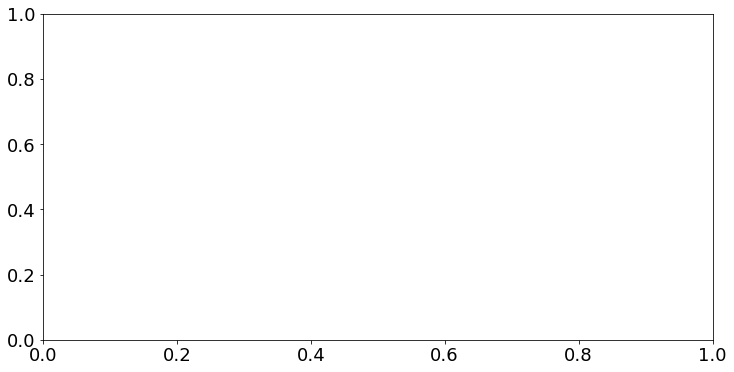

In [10]:
def plot_explore_coexistence_disciplines_over_time (selected_domain, selected_value, selected_discipline_1, selected_discipline_2, resampling, smoothing, max_value_y, readjust_colors):
    resampling_dict = {"Year": "Y", "Month": "M", "Day": "D"}
    resampling = resampling_dict[resampling]
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]    
    selected_disciplines = [selected_discipline_1, selected_discipline_2]
    if selected_value != "No value":
        selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
    explore_coexistence_disciplines_over_time(selected_dataset, dict_references["Research Areas"], selected_disciplines, resampling, smoothing, max_value_y, list_of_categories, readjust_colors)
widgets.interact(plot_explore_coexistence_disciplines_over_time, selected_domain = ["power generation", "mobility", "industry"], selected_value=[*dict_anchor_words, "No value"], smoothing = (0.25,3, 0.25), max_value_y = (5,100, 5), resampling = ["Year", "Month", "Day"], selected_discipline_1 = list_of_categories, selected_discipline_2 = list_of_categories, readjust_colors = (1,20, 1))

In [ ]:
# Collaboration about what? topic models of that?

In [59]:
T0 = "1960"
T1 = "2022"

def plot_topics_in_dataset (selected_domain, selected_value, selected_discipline_1, selected_discipline_2, number_of_topics_to_find, number_of_documents_in_analysis, number_of_words_per_topic):
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1)]    
    selected_dataset = selected_dataset.loc[(selected_dataset['date'] >= dateutil.parser.parse(str(T0))) & (selected_dataset['date'] <= dateutil.parser.parse(str(T1)))]
    selected_dataset = selected_dataset[selected_dataset[dict_references["Research Areas"]].str.contains(selected_discipline_1, na=False)]
    selected_dataset = selected_dataset[selected_dataset[dict_references["Research Areas"]].str.contains(selected_discipline_2, na=False)]
    if selected_value != "No value":
        selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
    list_rejected_words2 = []
    return explore_topics_in_dataset(selected_dataset, number_of_topics_to_find, number_of_documents_in_analysis, number_of_words_per_topic, list_rejected_words2)

my_interact_manual = interact_manual.options(manual_name="Find topics")
my_interact_manual(plot_topics_in_dataset, selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"],  number_of_topics_to_find = (5,50, 5), number_of_documents_in_analysis =(500,5000, 500), number_of_words_per_topic =(5,30, 5), selected_discipline_1 = list_of_categories, selected_discipline_2 = list_of_categories)

interactive(children=(Dropdown(description='selected_domain', options=('power_grid', 'mobility', 'industry'), …

<function __main__.plot_topics_in_dataset(selected_domain, selected_value, selected_discipline_1, selected_discipline_2, number_of_topics_to_find, number_of_documents_in_analysis, number_of_words_per_topic)>

## 10. Explore most important journals

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_histogram_source_titles(selected_value, selected_domain, number_of_top_journals, starttime, endtime)>

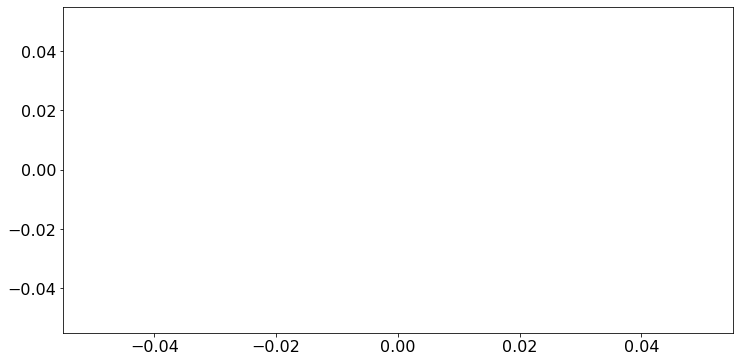

In [35]:
def plot_histogram_source_titles(selected_value, selected_domain, number_of_top_journals, starttime, endtime):
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]
    if selected_value != "No value":
        selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
    selected_dataset[dict_references["Publication Name"]].value_counts()[:number_of_top_journals].plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("Top journals for "+str(selected_domain)+" dataset")
    plt.show()

widgets.interact(plot_histogram_source_titles, selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"], number_of_top_journals =(5,30, 1), starttime =(1960,2020, 5), endtime =(1960,2025, 5))


## 11. Explore topics within a specific dataset

Number of articles in selected dataset: 590


./code\make_topic_model.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_topics_to_analyse["text_tagged"] = df_with_topics_to_analyse["text_tagged"].apply(lambda x: filter_stopwords_verbs(x, tags_to_select))


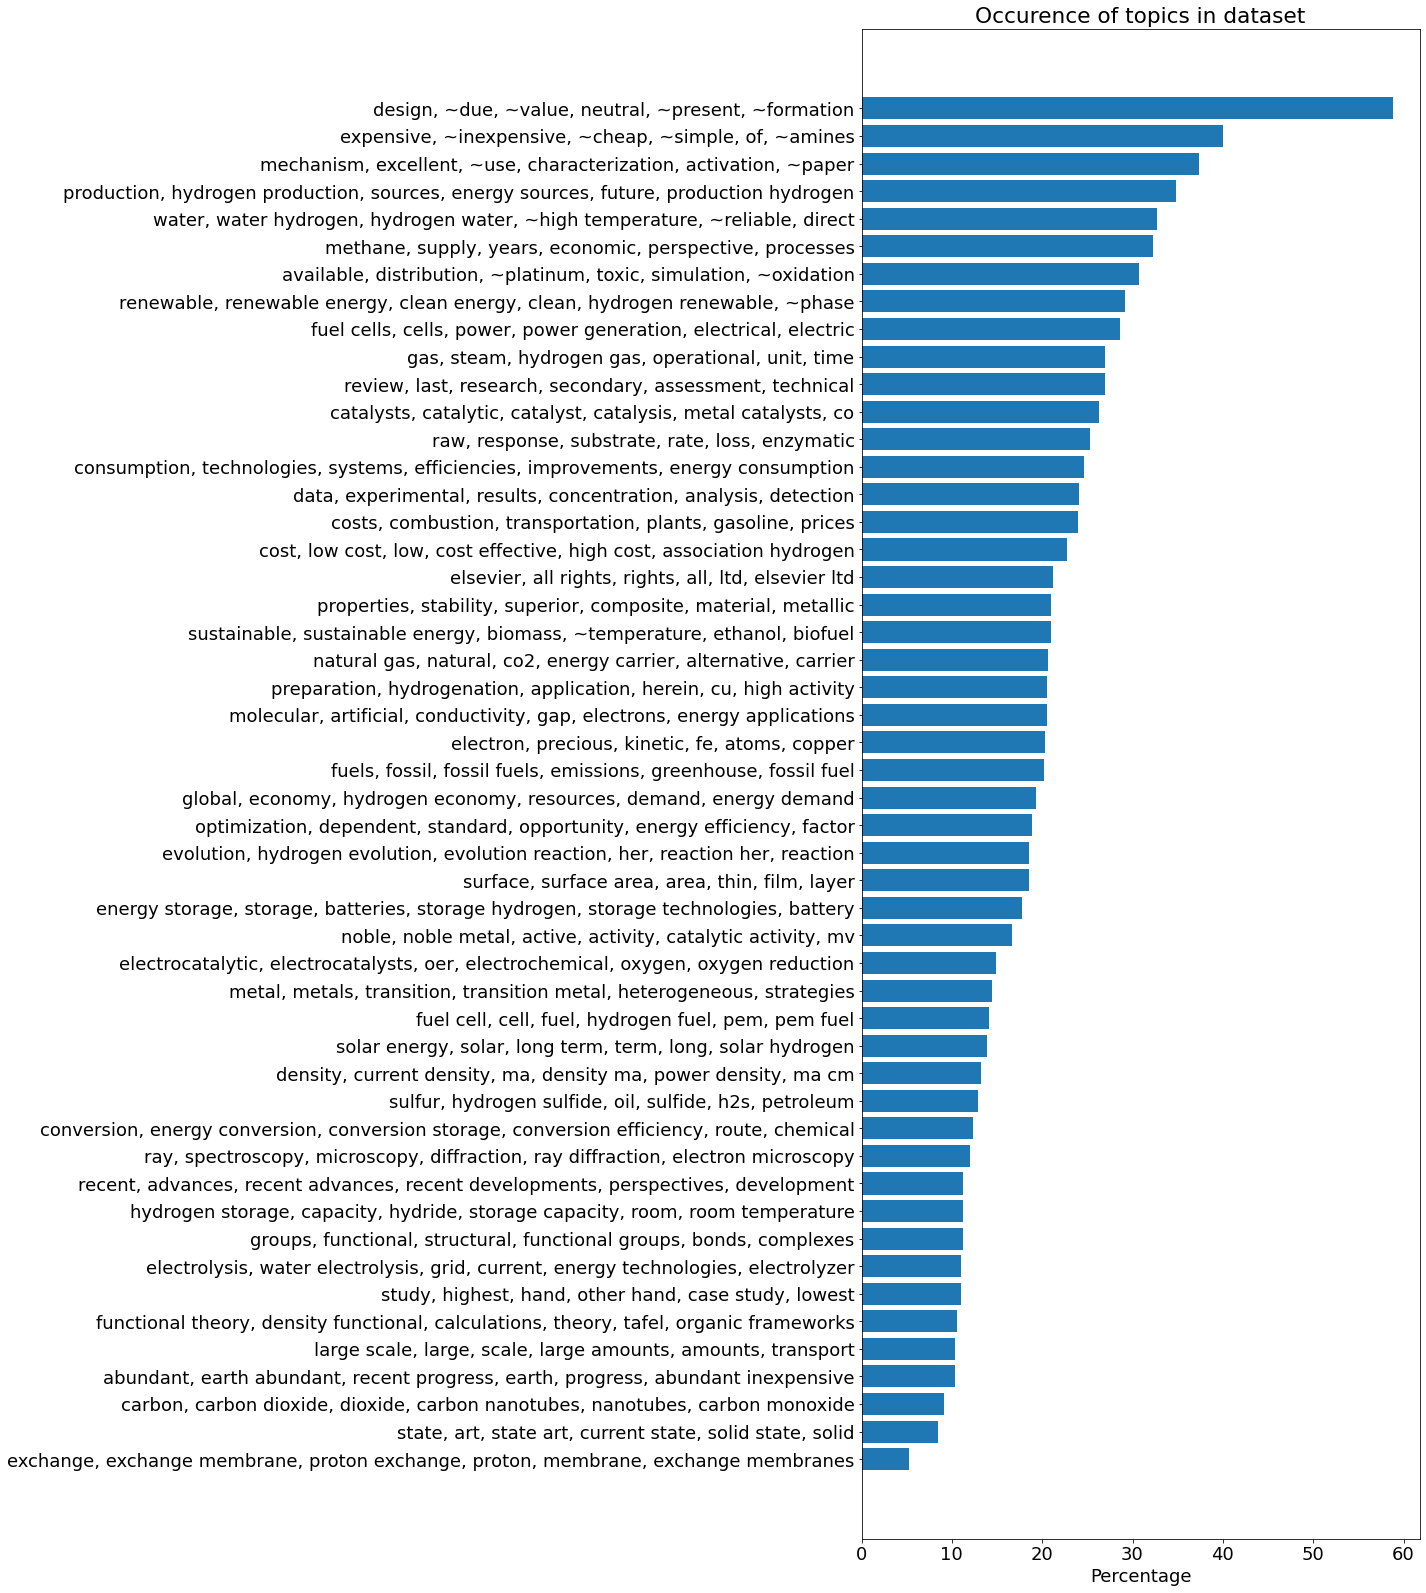

In [51]:
selected_value = "Affordability" # "Environmnental Sustainability", "Safety", "Economic viability", "Efficiency", "Affordability", "No value"
selected_domain= "all domains"     #["power generation", "mobility", "industry", "all domains"]
number_of_topics_to_find = 50
number_of_documents_in_analysis = 2000
max_number_of_words_per_topic = 6
top_topics_to_show = number_of_topics_to_find

selected_dataset = df_with_topics
if selected_value != "No value":
    selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
if  selected_domain != "all domains":
    selected_dataset = selected_dataset.loc[(selected_dataset[dict_domains[selected_domain]] == 1)]
if  selected_domain == "all domains":
    selected_dataset = selected_dataset.loc[(selected_dataset[dict_domains["power generation"]] == 1) | (selected_dataset[dict_domains["mobility"]] == 1) | (selected_dataset[dict_domains["industry"]] == 1)]
list_rejected_words2 = []
outcome_topic_model_2 = explore_topics_in_dataset(selected_dataset, number_of_topics_to_find, number_of_documents_in_analysis, max_number_of_words_per_topic, list_rejected_words2, top_topics_to_show)

In [52]:
#with open('save/outcome_topic_model_2_'+str(selected_domain)+'_'+str(selected_value)+'.pickle', 'wb') as handle:
#    pickle.dump(outcome_topic_model_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

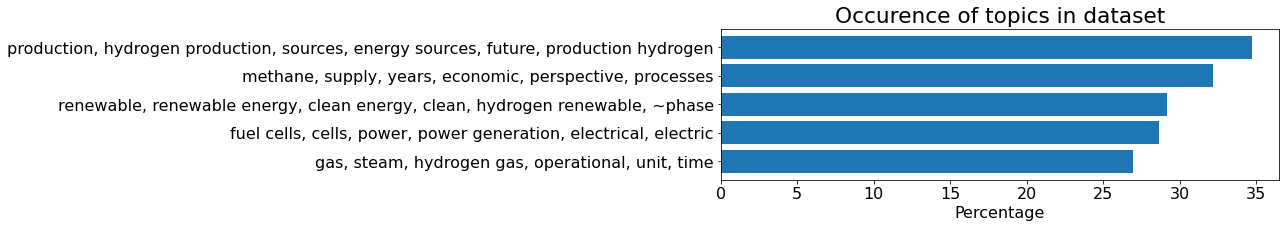

In [16]:
selected_value = "Affordability" # "Environmnental Sustainability", "Safety", "Economic viability", "Efficiency", "Affordability", "No value"
selected_domain= "all domains"     #["power generation", "mobility", "industry", "all domains"]
top_topics_to_show = 10

topics_to_remove = [
    
"design, ~due, ~value, neutral, ~present, ~formation", 
"expensive, ~inexpensive, ~cheap, ~simple, of, ~amines",
"mechanism, excellent, ~use, characterization, activation, ~paper",
#"production, hydrogen production, sources, energy sources, future, production hydrogen",
"water, water hydrogen, hydrogen water, ~high temperature, ~reliable, direct",
#"methane, supply, years, economic, perspective, processes",
"available, distribution, ~platinum, toxic, simulation, ~oxidation",
#"renewable, renewable energy, clean energy, clean, hydrogen renewable, ~phase",
#"fuel cells, cells, power, power generation, electrical, electric",
#"gas, steam, hydrogen gas, operational, unit, time",
"review, last, research, secondary, assessment, technical",
"catalysts, catalytic, catalyst, catalysis, metal catalysts, co",
"raw, response, substrate, rate, loss, enzymatic",
"consumption, technologies, systems, efficiencies, improvements, energy consumption",
"data, experimental, results, concentration, analysis, detection",
    
    
    
]


with open('save/outcome_topic_model_2_'+str(selected_domain)+'_'+str(selected_value)+'.pickle', "rb") as input_file:
    outcome_topic_model_2 = cPickle.load(input_file)

df_with_topics_sum_dataset_short = outcome_topic_model_2[0][outcome_topic_model_2[1]]
df_sum_dataset_short = df_with_topics_sum_dataset_short.sum(numeric_only=True)
series_perc_dataset_short = df_sum_dataset_short.apply(lambda x: x / len(df_with_topics_sum_dataset_short) * 100)
series_perc_dataset_short = series_perc_dataset_short.sort_values(ascending=False)
series_perc_dataset_short = series_perc_dataset_short [:top_topics_to_show]
    
dict_dataset_short = series_perc_dataset_short.to_dict()
dict_dataset_short = {key: dict_dataset_short[key] for key in dict_dataset_short if key not in topics_to_remove}
plt.figure(figsize=(10,len(dict_dataset_short) / 1.8))
plt.barh(list(dict_dataset_short.keys()), list(dict_dataset_short.values()))
plt.gca().invert_yaxis()
    
plt.rcParams.update({'font.size': 18})
plt.title('Occurence of topics in dataset')
plt.xlabel('Percentage')
plt.show()

In [18]:
outcome_topic_model_2[1]

['design, ~due, ~value, neutral, ~present, ~formation',
 'expensive, ~inexpensive, ~cheap, ~simple, of, ~amines',
 'mechanism, excellent, ~use, characterization, activation, ~paper',
 'production, hydrogen production, sources, energy sources, future, production hydrogen',
 'water, water hydrogen, hydrogen water, ~high temperature, ~reliable, direct',
 'methane, supply, years, economic, perspective, processes',
 'available, distribution, ~platinum, toxic, simulation, ~oxidation',
 'renewable, renewable energy, clean energy, clean, hydrogen renewable, ~phase',
 'fuel cells, cells, power, power generation, electrical, electric',
 'gas, steam, hydrogen gas, operational, unit, time',
 'review, last, research, secondary, assessment, technical',
 'catalysts, catalytic, catalyst, catalysis, metal catalysts, co',
 'raw, response, substrate, rate, loss, enzymatic',
 'consumption, technologies, systems, efficiencies, improvements, energy consumption',
 'data, experimental, results, concentration,

In [87]:
dict_topics = {}
counter = 0
for i in outcome_topic_model_2[1]:
    dict_topics[counter] = i 
    counter = counter + 1

NameError: name 'outcome_topic_model_2' is not defined

Topic 3: production, hydrogen production, sources, energy sources, future, production hydrogen
Topic 5: methane, supply, years, economic, perspective, processes
Topic 7: renewable, renewable energy, clean energy, clean, hydrogen renewable, ~phase
Topic 8: fuel cells, cells, power, power generation, electrical, electric
Topic 9: gas, steam, hydrogen gas, operational, unit, time


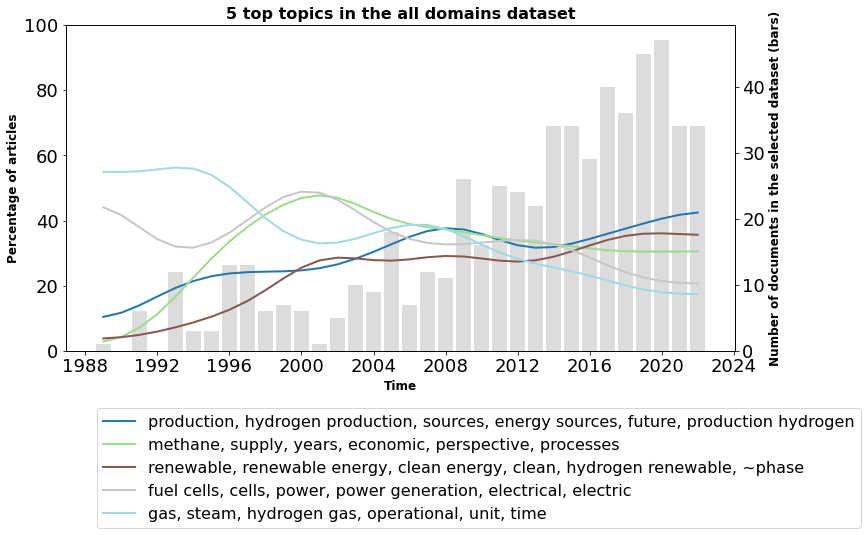

In [60]:
top_topics_to_show = 5
readjust_colors = 11
max_value_y = 100
T0 = "1960"
T1 = "2022"
smoothing = 1
resampling = "Y"
topics_to_remove = [

"design, ~due, ~value, neutral, ~present, ~formation", 
"expensive, ~inexpensive, ~cheap, ~simple, of, ~amines",
"mechanism, excellent, ~use, characterization, activation, ~paper",
#"production, hydrogen production, sources, energy sources, future, production hydrogen",
"water, water hydrogen, hydrogen water, ~high temperature, ~reliable, direct",
#"methane, supply, years, economic, perspective, processes",
"available, distribution, ~platinum, toxic, simulation, ~oxidation",
#"renewable, renewable energy, clean energy, clean, hydrogen renewable, ~phase",
#"fuel cells, cells, power, power generation, electrical, electric",
#"gas, steam, hydrogen gas, operational, unit, time",
"review, last, research, secondary, assessment, technical",
"catalysts, catalytic, catalyst, catalysis, metal catalysts, co",
"raw, response, substrate, rate, loss, enzymatic",
"consumption, technologies, systems, efficiencies, improvements, energy consumption",
"data, experimental, results, concentration, analysis, detection",
]


df_to_evaluate = outcome_topic_model_2[0]
df_to_evaluate = df_to_evaluate.loc[(df_to_evaluate['date'] >= dateutil.parser.parse(str(T0))) & (df_to_evaluate['date'] <= dateutil.parser.parse(str(T1)))]

df_to_evaluate = df_to_evaluate.set_index('date')  

        
df_with_topics_freq = df_to_evaluate.resample(resampling).size().reset_index(name="count")
df_with_topics_freq = df_with_topics_freq.set_index('date')
      
df_to_evaluate = df_to_evaluate.fillna("")

df_to_evaluate = df_to_evaluate[list(dict_topics.values())]
#print(df_to_evaluate)
df_to_evaluate = df_to_evaluate.drop(columns=topics_to_remove)

df_to_evaluate = df_to_evaluate.resample(resampling).sum()
count_df_to_evaluate = df_to_evaluate.sum()
initial_number_topics = len(count_df_to_evaluate)
count_df_to_evaluate = count_df_to_evaluate[:top_topics_to_show]

percentage_df_to_evaluate = count_df_to_evaluate.divide(count_df_to_evaluate.sum(), fill_value=0)
percentage_df_to_evaluate = percentage_df_to_evaluate * 100
list_topics_above_threshold = list(count_df_to_evaluate.index.values)

#list_topics_above_threshold = [
#    "spectroscopy, optical, resonance, spectra, spectrum, electron",
#    "fossil, fuels, carbon dioxide, co2, technologies, dioxide",
#    "of, and, in, the, for, on",
#    "antioxidant, h2o2, peroxide, radical, hydrogen peroxide, superoxide",
#    "electrochemical, electrode, performance, high performance, electrochemical performance, electrochemical energy",
#    "plasma, rf, vapor deposition, beam, chemical vapor, vapor",    
#]

#print topics
for topic in list_topics_above_threshold:
    print("Topic "+str(list(dict_topics.values()).index(topic))+": "+str(topic))


df_to_evaluate = df_to_evaluate[list_topics_above_threshold]
    
df_to_evaluate = df_to_evaluate.div(df_with_topics_freq["count"], axis=0)
df_to_evaluate = df_to_evaluate.fillna(0)
    
     
x = pd.Series(df_to_evaluate.index.values)
x = x.dt.to_pydatetime().tolist()
    
x = [ z - relativedelta(years=1) for z in x]
      
df_to_evaluate = df_to_evaluate * 100

    
sigma = (np.log(len(x)) - 1.25) * 1.2 * smoothing
        
#n_colors = initial_number_topics
#colours = cm.tab20(np.linspace(0, 1, math.ceil(n_colors / readjust_colors)))
colours = cm.tab20(np.linspace(0, 1, math.ceil(len(list_topics_above_threshold))))
colours_long = []
for i in range(readjust_colors):
    for y in colours:
        colours_long.append(y)

dict_colors = {}
counter = 0
for word in list_topics_above_threshold:
    dict_colors[word] = colours_long[counter]
    counter = counter + 1

counter = 0
fig, ax1 = plt.subplots()
for word in df_to_evaluate:
    ysmoothed = gaussian_filter1d(df_to_evaluate[word].tolist(), sigma=sigma)
    ax1.plot(x, ysmoothed, label=word, linewidth=2, color = dict_colors[word])
    counter = counter + 1
        
ax1.set_xlabel('Time', fontsize=12, fontweight="bold")
ax1.set_ylabel('Percentage of articles', fontsize=12, fontweight="bold")
ax1.legend(prop={'size': 10})
    
timestamp_0 = x[0]
timestamp_1 = x[1]
    

#width = (time.mktime(timestamp_1.timetuple()) - time.mktime(timestamp_0.timetuple())) / 86400 *.8
width = (timestamp_1 - timestamp_0).total_seconds() / 86400 * 0.8
    
df_to_evaluate["count"]=df_with_topics_freq["count"]
    
ax2 = ax1.twinx()
ax2.bar(x, df_to_evaluate["count"].tolist(), width=width, color='gainsboro')
ax2.set_ylabel('Number of documents in the selected dataset (bars)', fontsize=12, fontweight="bold")
    
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

        
ax1.set_ylim([0,max_value_y])
ax1.legend(bbox_to_anchor=(1.2, -0.15), prop={'size': 16})
    
plt.rcParams["figure.figsize"] = [12,6]
plt.title("5 top topics in the "+str(selected_domain)+" dataset", fontsize=16, fontweight="bold")
plt.show()

In [61]:
list_string = df_with_topics[dict_references["Research Areas"]].str.cat(sep=';')
list_split = list_string.split(';') 
list_split_all=[x.strip(' ') for x in list_split]
count = Counter(list_split_all) 
list_of_categories=list(count.keys())
list_of_categories.sort()
len(list_of_categories)

222

Topic 3: production, hydrogen production, sources, energy sources, future, production hydrogen
Topic 5: methane, supply, years, economic, perspective, processes
Topic 7: renewable, renewable energy, clean energy, clean, hydrogen renewable, ~phase
Topic 8: fuel cells, cells, power, power generation, electrical, electric
Topic 9: gas, steam, hydrogen gas, operational, unit, time


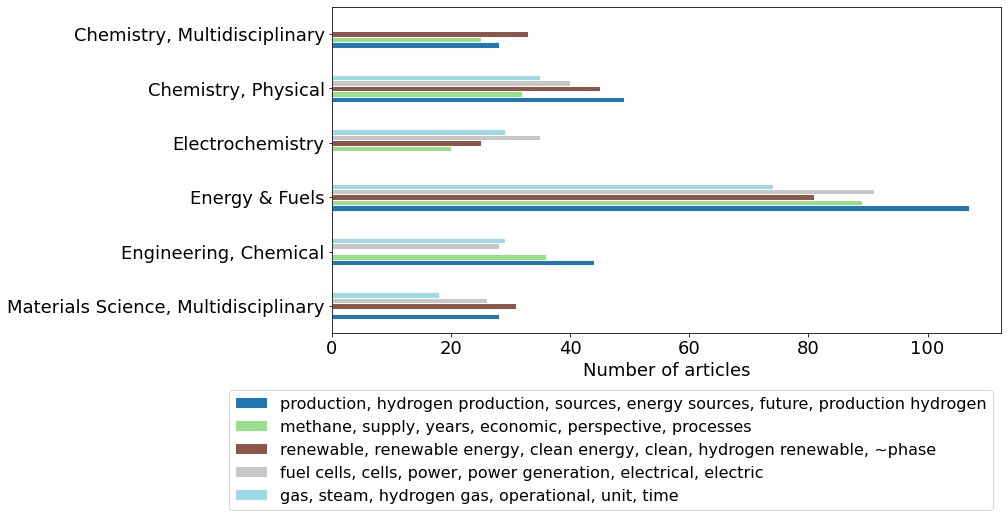

In [62]:
top_categories = 5
topic = 0
#selected_domain = "mobility"    #"power generation", "mobility", "industry"


#list_domains = list(list_domains[0])

dict_of_dict_domains = {}
df_categories = pd.DataFrame()
#list_domains = [selected_domain]


dict_of_dict_domains = {}
df_categories = pd.DataFrame()
for topic in list_topics_above_threshold:
    print("Topic "+str(list(dict_topics.values()).index(topic))+": "+str(topic))
    selected_dataset = outcome_topic_model_2[0]
    selected_dataset = selected_dataset.loc[(selected_dataset[topic] == 1)]
    selected_dataset = selected_dataset.fillna("")
    df_category = pd.DataFrame() 
    for word in list_of_categories:
        new_df = pd.DataFrame()
        new_df[word] = selected_dataset[dict_references["Research Areas"]].str.contains(pat = word).astype(int)
        #print(new_df[word])
        df_category = pd.concat([df_category, new_df], axis=1)
    sum_df = df_category.sum()
    sorted_sum_df = sum_df.sort_values(ascending=False)
    sorted_sum_df = sorted_sum_df[:top_categories]
    df_categories = pd.concat([df_categories, sorted_sum_df], axis=1)

df_categories = df_categories.sort_index(ascending=False)
#print(df_categories)
df_categories.columns = list_topics_above_threshold
df_categories = df_categories.fillna(0)
ax = df_categories.plot(y=list_topics_above_threshold, kind="barh", edgecolor='white', linewidth=1, color = dict_colors)
ax.set_xlabel("Number of articles")
ax.legend(bbox_to_anchor=(1, -0.15), prop={'size': 16})

In [66]:
selected_topic = 9
size_sample = 30
sampled_or_sorting = "sorting" # "sampled", "sorting"

df_with_topics_to_analyse = outcome_topic_model_2[0].loc[outcome_topic_model_2[0][dict_topics[selected_topic]] > 0]

df_with_topics_to_analyse = df_with_topics_to_analyse[df_with_topics_to_analyse['NR'].notna()]
df_with_topics_to_analyse['NR'] = df_with_topics_to_analyse['NR'].astype('int')

if sampled_or_sorting == "sampled":
    df_with_topics_to_analyse = df_with_topics_to_analyse.sample(n = min(size_sample, len(df_with_topics_to_analyse)))
if sampled_or_sorting == "sorting":
    df_with_topics_to_analyse = df_with_topics_to_analyse.sort_values(by=[dict_references["Citation counts"]], ascending=False)
    df_with_topics_to_analyse = df_with_topics_to_analyse.head(size_sample)


tokens = dict_topics[selected_topic].split(',')
tokens = [i.strip() for i in tokens]
print("Topic selected: "+str(tokens))

print("")
for index, row in df_with_topics_to_analyse.iterrows():
    print('\033[1m' + 'Article '+str(index) + '\033[0m')
    if dict_references['Document Title'] in df_with_topics_to_analyse:
        print("Title: "+str(row[dict_references['Document Title']]))
    if dict_references['Authors'] in df_with_topics_to_analyse:
        print("Authors: "+str(row[dict_references['Authors']]))
    if dict_references['Author Keywords'] in df_with_topics_to_analyse:
        print("Author Keywords: "+str(row[dict_references['Author Keywords']]))
    if 'date' in df_with_topics_to_analyse:
        print("Publication date: "+str(row['date']))
    if dict_references['Publication Name'] in df_with_topics_to_analyse:
        print("Source title: "+str(row[dict_references['Publication Name']]))
    if sampled_or_sorting == "sorting" and dict_references['Authors'] in df_with_topics_to_analyse:
        print("Citation counts: "+str(row[dict_references['Citation counts']]))
    if dict_references['Abstract'] in df_with_topics_to_analyse:
        text_combined_not_tagged = row[dict_references['Abstract']]
        for word in tokens:
            try:
                text_combined_not_tagged = re.sub(word, '\033[1m' + '[' + str(red(word)) + ']' + '\033[0m', text_combined_not_tagged, flags=re.IGNORECASE)
            except:
                print("Article skipped")
        print("Abstract: "+str(text_combined_not_tagged))
    print("")
    print("")



Topic selected: ['gas', 'steam', 'hydrogen gas', 'operational', 'unit', 'time']

Article 233099
Title: Catalytic Upgrading of Biomass Model Compounds: Novel Approaches and Lessons Learnt from Traditional Hydrodeoxygenation - a Review
Authors: Jin, W; Pastor-Perez, L; Shen, DK; Sepulveda-Escribano, A; Gu, S; Reina, TR
Author Keywords: Hydrodeoxygenation; biomass model compounds; HDO catalyst; reforming; catalytic transfer hydrogenation; metal hydrolysis; non-thermal plasma
Publication date: 2019-11-28 00:00:00
Source title: CHEMCATCHEM
Citation counts: 291
Abstract: Catalytic hydrodeoxygenation (HDO) is a fundamental process for bio-resources upgrading to produce transportation fuels or added value chemicals. The bottleneck of this technology to be implemented at commercial scale is its dependence on high pressure hydrogen, an expensive resource which utilization also poses safety concerns. In this scenario, the development of hydrogen-free alternatives to facilitate oxygen removal in b

## 12. Sentiment analysis

In [57]:
def plot_sentiment(selected_value, selected_domain, starttime, endtime):
    selected_dataset = df_with_topics.loc[(df_with_topics[dict_domains[selected_domain]] == 1) & (df_with_topics['date'] >= dateutil.parser.parse(str(starttime))) & (df_with_topics['date'] < dateutil.parser.parse(str(endtime)))]

    if selected_value != "No value":
        selected_dataset = selected_dataset.loc[(selected_dataset[dict_values[selected_value]] == 1)]
        
    selected_dataset['polarity'] = selected_dataset['text'].apply(lambda x: analyzer.polarity_scores(x))
    selected_dataset = pd.concat([selected_dataset.drop(['polarity'], axis=1), selected_dataset['polarity'].apply(pd.Series)], axis=1)
    selected_dataset['sentiment'] = selected_dataset['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
    sns.countplot(y='sentiment', 
                 data=selected_dataset, 
                 palette=['#b2d8d8',"#008080", '#db3d13']
                 );
    plt.show()
    
    g = sns.lineplot(x='date', y='compound', data=selected_dataset)

    g.set(xticklabels=[]) 
    g.set(title='Sentiment of articles')
    g.set(xlabel="Time")
    g.set(ylabel="Sentiment")
    g.tick_params(bottom=False)

    g.axhline(0, ls='--', c = 'grey')
    plt.show()
    
    sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=selected_dataset);
    plt.show()

my_interact_manual = interact_manual.options(manual_name="Plot sentiment")
my_interact_manual(plot_sentiment, selected_value=[*dict_anchor_words, "No value"], selected_domain = ["power generation", "mobility", "industry"], starttime =(1960,2025, 5), endtime =(1960,2025, 5))

interactive(children=(Dropdown(description='selected_value', options=('Environmnental Sustainability', 'Safety…

<function __main__.plot_sentiment(selected_value, selected_domain, starttime, endtime)>